In [ ]:
#mounting the drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#data import
import pandas as pd
df= pd.read_csv('gdrive/MyDrive/PersonalReason.csv')

In [ ]:
#remove from the 'EXIT' column the completed data to avoid bias or overfitting
df = df[df.Reason != 'Completed']

In [ ]:
df.head()

,Unnamed: 0,PersonalStatement,Reason
109,120,Jurgen Klopp is a good coach in the modern era...,Other personal reasons & dropped out
110,121,I'm exploring two different courses in which I...,Other
112,124,"Technology. To me, a wonderful thing to explor...",Other personal reasons & dropped out
124,137,"""When something is important enough, you do it...",Gone into employment
133,146,Psychology became a passion of mine when I sta...,Other personal reasons & dropped out


In [ ]:
#remove the unnamed column
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

#**DATA PREPROCESSING**

In [ ]:
df['category_id'] = df['Reason'].factorize()[0]
from io import StringIO
category_id_df = df[['Reason', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Reason']].values)

**STATISTIC**

In [ ]:
stats = df.groupby("Reason")

# Summary statistic of all countries
stats.describe().head(8)

category_id                 \
                                                         count mean  std  min   
Reason                                                                          
Academic failure/left in bad standing/not permi...         8.0  5.0  0.0  5.0   
Exclusion                                                  2.0  7.0  0.0  7.0   
Financial reasons                                          5.0  6.0  0.0  6.0   
Gone into employment                                      26.0  2.0  0.0  2.0   
Health reasons                                            23.0  3.0  0.0  3.0   
Other                                                     66.0  1.0  0.0  1.0   
Other personal reasons & dropped out                      93.0  0.0  0.0  0.0   
Transferred to another provider                           46.0  4.0  0.0  4.0   

                                                                        
                                                    25%  50%  75%  max  
Reason                                                                  
Academic failure/left in bad standing/not permi...  5.0  5.0  5.0  5.0  
Exclusion                                           7.0  7.0  7.0  7.0  
Financial reasons                                   6.0  6.0  6.0  6.0  
Gone into employment                                2.0  2.0  2.0  2.0  
Health reasons                                      3.0  3.0  3.0  3.0  
Other                                               1.0  1.0  1.0  1.0  
Other personal reasons & dropped out                0.0  0.0  0.0  0.0  
Transferred to another provider                     4.0  4.0  4.0  4.0

#**ENCODING PERSONAL STATMENTS USING TFIDFVectorizer**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=4, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.PersonalStatement).toarray()
labels = df.category_id
features.shape

(269, 3843)

**OBTAINING COMMON UNIGRAMS AND BIGRAMS *WORDS* FROM PERSONAL STATEMENTS USING THE CHI2 PACKAGE FROM SCIKIT LEARN**

In [ ]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is d

# 'Academic failure/left in bad standing/not permitted to progress':
  . Most correlated unigrams:
       . distressed
       . depending
  . Most correlated bigrams:
       . adult nursing
       . nursing course
# 'Exclusion':
  . Most correlated unigrams:
       . disciplinary
       . paramedic
  . Most correlated bigrams:
       . high quality
       . clinical skills
# 'Financial reasons':
  . Most correlated unigrams:
       . match
       . excitement
  . Most correlated bigrams:
       . want learn
       . want help
# 'Gone into employment':
  . Most correlated unigrams:
       . seeking
       . phone
  . Most correlated bigrams:
       . allow develop
       . current job
# 'Health reasons':
  . Most correlated unigrams:
       . mock
       . postgraduate
  . Most correlated bigrams:
       . graphic design
       . different settings
# 'Other':
  . Most correlated unigrams:
       . punctuality
       . gift
  . Most correlated bigrams:
       . worked children
       . c

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


**SPLITTING THE DATA INTO TRAINING AND TESTING DATA**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['PersonalStatement'], df['Reason'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [ ]:
print(clf.predict(count_vect.transform(["I am applying for Marine biology because I believe it is incredibly important to study and conserve marine life on this planet because they are very important to the wellbeing of humans. I think it is important because marine biologists study the environment and ocean and how to make sustainable ways so that human beings can utilize resources from the ocean to improve the wellbeing of humans because the ocean provides one sixth of animal protein humans eat and living oceans absorb carbon dioxide from the atmosphere reducing the effects on climate change. With overfishing and the damage to the habitats I believe it is incredibly important to protect and conserve marine life which interests me in a marine biology degree. I have always been fascinated by marine life because I spent a lot of my time on boats and around the sea so it has made me passionate about the subject so it is something I would love to study.I am currently studying Biology, Geography and Maths which all provide me with relative knowledge to the course I want to study. Biology provides me with the foundation I need to study this course because I have learnt about how climate change can affect living animals and the problems caused and what can be done to reduce the problems which is a key aspect of the course. Biology has also allowed me to learn about the ecology of animals and how they can survive in a specific environment. I have also been on a residential trip to Wales where we studied the coastal areas and the wildlife around them which required me to use key skills which improved my research skills and will benefit me in the course. Geography has allowed me to study the environment and climate change and how humans affect it like global warming which is causing a rise in the sea temperature which causes coral bleaching affecting the habitat where a lot of marine life lives it also allows me to learn about coastal habitats and there importance to marine life and ways to prevent increasing problems caused by humans. Maths has given me vital skills for analysing and collecting statistical data which is very important to show changes in data so that comparisons can be made so we know how to prevent further effects of change to preserve the habitats.I completed my work experience at a company called Zenith Hygiene where I took part in day to day laboratory analysis of samples received from an in house laboratory. These included total viable counts, selective coliforms, lactic acid bacteria and clostridium spp. All the work I completed there was microbiology based, I tested these samples which gave me an insight into the testing required for different samples which I feel was very useful and helped me to gain a more scientific mind-set that I could apply to different testing and research that might be required in the course.In my spare time I attended Air Cadets which taught me how to work as a team and helped build my confidence and leadership skills. I also played football for Lymm piranhas for 7 years which helped me work well in a team, also I captained the team for the last 2 years which helped me to increase my leadership skills.In the future I wish to work in an active environment where I can put the skills I learned to use in fieldwork or research."])))


['Other personal reasons & dropped out']


#**MODELLING**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB


from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 2
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

**BOXPLOT OF ACCURACY**

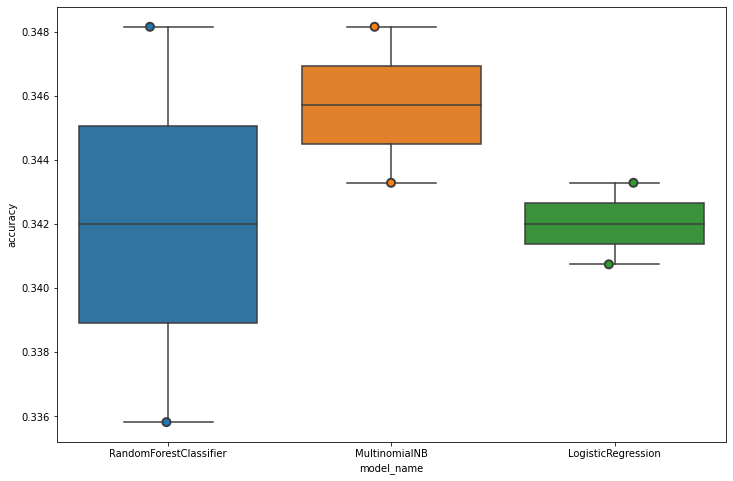

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,8))
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [ ]:
#group modelling result against accuracy using function groupby
cv_df.groupby('model_name').accuracy.mean()


model_name
LogisticRegression        0.342012
MultinomialNB             0.345716
RandomForestClassifier    0.341985
Name: accuracy, dtype: float64

In [ ]:
#split data into training and testing dataset using the train_test_split package with test data set to 10%
from sklearn.model_selection import train_test_split

model = MultinomialNB()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.10, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#**CONFUSION MATRIX**

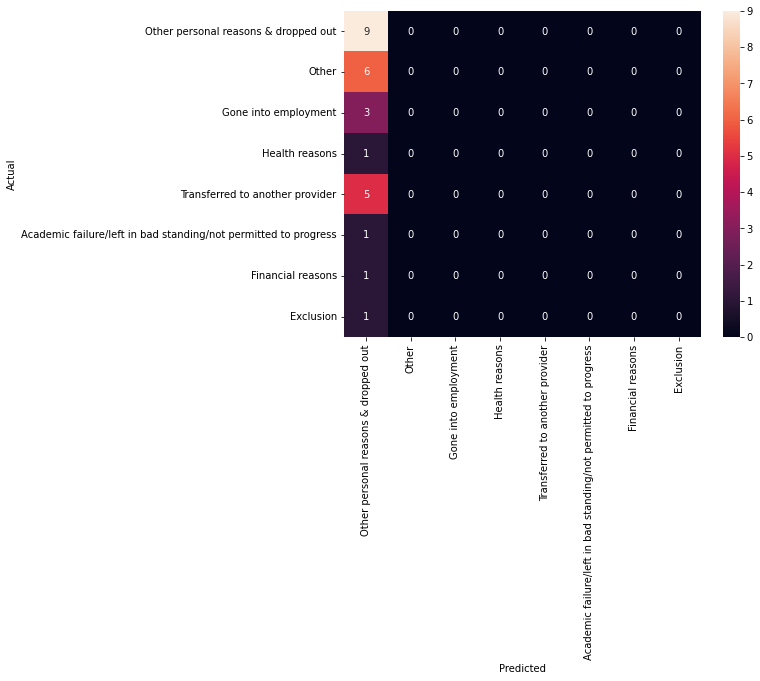

In [ ]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Reason.values, yticklabels=category_id_df.Reason.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**PREDICTING USING CATEGORY ID**

In [ ]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 0:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Reason', 'PersonalStatement']])
      print('')

'Other' predicted as 'Other personal reasons & dropped out' : 6 examples.


,Reason,PersonalStatement
4619,Other,When my grandfather was admitted into hospital...
3952,Other,From a young age I have always enjoyed taking ...
3535,Other,I am applying to marine biology courses as i f...
3566,Other,From a young age my mother cared for children ...
3544,Other,I first developed an interest in Biological Sc...
4129,Other,Geography is a very important subject that stu...



'Gone into employment' predicted as 'Other personal reasons & dropped out' : 3 examples.


,Reason,PersonalStatement
3237,Gone into employment,Due to major complications faced by society to...
2132,Gone into employment,I am applying to study a bachelor's degree in ...
1337,Gone into employment,I want to gain a full understanding of the cau...



'Health reasons' predicted as 'Other personal reasons & dropped out' : 1 examples.


,Reason,PersonalStatement
186,Health reasons,Social work to me means to support others in t...



'Transferred to another provider' predicted as 'Other personal reasons & dropped out' : 5 examples.


,Reason,PersonalStatement
2424,Transferred to another provider,I have always had a curiosity for animal life ...
2877,Transferred to another provider,Business is at the heart of every organisation...
2413,Transferred to another provider,My career ambition is to study Adult Nursing a...
3730,Transferred to another provider,"Throughout my school career, I keenly particip..."
2851,Transferred to another provider,I am applying for marine biology because I am ...



'Academic failure/left in bad standing/not permitted to progress' predicted as 'Other personal reasons & dropped out' : 1 examples.


,Reason,PersonalStatement
3811,Academic failure/left in bad standing/not perm...,I would like to be a Mental Health Nurse becau...



'Financial reasons' predicted as 'Other personal reasons & dropped out' : 1 examples.


,Reason,PersonalStatement
4458,Financial reasons,Oliver Glover - Personal Statement.\r\n\r\nIt ...



'Exclusion' predicted as 'Other personal reasons & dropped out' : 1 examples.


,Reason,PersonalStatement
1564,Exclusion,Never knowing what my job will entail each day...



'Other personal reasons & dropped out' predicted as 'Other' : 0 examples.


,Reason,PersonalStatement



'Gone into employment' predicted as 'Other' : 0 examples.


,Reason,PersonalStatement



'Health reasons' predicted as 'Other' : 0 examples.


,Reason,PersonalStatement



'Transferred to another provider' predicted as 'Other' : 0 examples.


,Reason,PersonalStatement



'Academic failure/left in bad standing/not permitted to progress' predicted as 'Other' : 0 examples.


,Reason,PersonalStatement



'Financial reasons' predicted as 'Other' : 0 examples.


,Reason,PersonalStatement



'Exclusion' predicted as 'Other' : 0 examples.


,Reason,PersonalStatement



'Other personal reasons & dropped out' predicted as 'Gone into employment' : 0 examples.


,Reason,PersonalStatement



'Other' predicted as 'Gone into employment' : 0 examples.


,Reason,PersonalStatement



'Health reasons' predicted as 'Gone into employment' : 0 examples.


,Reason,PersonalStatement



'Transferred to another provider' predicted as 'Gone into employment' : 0 examples.


,Reason,PersonalStatement



'Academic failure/left in bad standing/not permitted to progress' predicted as 'Gone into employment' : 0 examples.


,Reason,PersonalStatement



'Financial reasons' predicted as 'Gone into employment' : 0 examples.


,Reason,PersonalStatement



'Exclusion' predicted as 'Gone into employment' : 0 examples.


,Reason,PersonalStatement



'Other personal reasons & dropped out' predicted as 'Health reasons' : 0 examples.


,Reason,PersonalStatement



'Other' predicted as 'Health reasons' : 0 examples.


,Reason,PersonalStatement



'Gone into employment' predicted as 'Health reasons' : 0 examples.


,Reason,PersonalStatement



'Transferred to another provider' predicted as 'Health reasons' : 0 examples.


,Reason,PersonalStatement



'Academic failure/left in bad standing/not permitted to progress' predicted as 'Health reasons' : 0 examples.


,Reason,PersonalStatement



'Financial reasons' predicted as 'Health reasons' : 0 examples.


,Reason,PersonalStatement



'Exclusion' predicted as 'Health reasons' : 0 examples.


,Reason,PersonalStatement



'Other personal reasons & dropped out' predicted as 'Transferred to another provider' : 0 examples.


,Reason,PersonalStatement



'Other' predicted as 'Transferred to another provider' : 0 examples.


,Reason,PersonalStatement



'Gone into employment' predicted as 'Transferred to another provider' : 0 examples.


,Reason,PersonalStatement



'Health reasons' predicted as 'Transferred to another provider' : 0 examples.


,Reason,PersonalStatement



'Academic failure/left in bad standing/not permitted to progress' predicted as 'Transferred to another provider' : 0 examples.


,Reason,PersonalStatement



'Financial reasons' predicted as 'Transferred to another provider' : 0 examples.


,Reason,PersonalStatement



'Exclusion' predicted as 'Transferred to another provider' : 0 examples.


,Reason,PersonalStatement



'Other personal reasons & dropped out' predicted as 'Academic failure/left in bad standing/not permitted to progress' : 0 examples.


,Reason,PersonalStatement



'Other' predicted as 'Academic failure/left in bad standing/not permitted to progress' : 0 examples.


,Reason,PersonalStatement



'Gone into employment' predicted as 'Academic failure/left in bad standing/not permitted to progress' : 0 examples.


,Reason,PersonalStatement



'Health reasons' predicted as 'Academic failure/left in bad standing/not permitted to progress' : 0 examples.


,Reason,PersonalStatement



'Transferred to another provider' predicted as 'Academic failure/left in bad standing/not permitted to progress' : 0 examples.


,Reason,PersonalStatement



'Financial reasons' predicted as 'Academic failure/left in bad standing/not permitted to progress' : 0 examples.


,Reason,PersonalStatement



'Exclusion' predicted as 'Academic failure/left in bad standing/not permitted to progress' : 0 examples.


,Reason,PersonalStatement



'Other personal reasons & dropped out' predicted as 'Financial reasons' : 0 examples.


,Reason,PersonalStatement



'Other' predicted as 'Financial reasons' : 0 examples.


,Reason,PersonalStatement



'Gone into employment' predicted as 'Financial reasons' : 0 examples.


,Reason,PersonalStatement



'Health reasons' predicted as 'Financial reasons' : 0 examples.


,Reason,PersonalStatement



'Transferred to another provider' predicted as 'Financial reasons' : 0 examples.


,Reason,PersonalStatement



'Academic failure/left in bad standing/not permitted to progress' predicted as 'Financial reasons' : 0 examples.


,Reason,PersonalStatement



'Exclusion' predicted as 'Financial reasons' : 0 examples.


,Reason,PersonalStatement



'Other personal reasons & dropped out' predicted as 'Exclusion' : 0 examples.


,Reason,PersonalStatement



'Other' predicted as 'Exclusion' : 0 examples.


,Reason,PersonalStatement



'Gone into employment' predicted as 'Exclusion' : 0 examples.


,Reason,PersonalStatement



'Health reasons' predicted as 'Exclusion' : 0 examples.


,Reason,PersonalStatement



'Transferred to another provider' predicted as 'Exclusion' : 0 examples.


,Reason,PersonalStatement



'Academic failure/left in bad standing/not permitted to progress' predicted as 'Exclusion' : 0 examples.


,Reason,PersonalStatement



'Financial reasons' predicted as 'Exclusion' : 0 examples.


,Reason,PersonalStatement


In [ ]:
model.fit(features, labels)


MultinomialNB()

**OBTAINING COMMON UNIGRAMS AND BIGRAMS *WORDS* FROM PERSONAL STATEMENTS USING THE CHI2 PACKAGE FROM SCIKIT LEARN**

In [ ]:
from sklearn.feature_selection import chi2

N = 2
for Reason, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Reason))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Academic failure/left in bad standing/not permitted to progress':
  . Top unigrams:
       . nursing
       . care
  . Top bigrams:
       . adult nursing
       . nursing course
# 'Exclusion':
  . Top unigrams:
       . paramedic
       . care
  . Top bigrams:
       . clinical skills
       . high quality
# 'Financial reasons':
  . Top unigrams:
       . want
       . day
  . Top bigrams:
       . want help
       . help people
# 'Gone into employment':
  . Top unigrams:
       . work
       . course
  . Top bigrams:
       . work experience
       . time management
# 'Health reasons':
  . Top unigrams:
       . skills
       . psychology
  . Top bigrams:
       . mental health
       . computer science
# 'Other':
  . Top unigrams:
       . work
       . skills
  . Top bigrams:
       . primary school
       . communication skills
# 'Other personal reasons & dropped out':
  . Top unigrams:
       . skills
       . work
  . Top bigrams:
       . work experience
       . mental heal

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


#**PREDICTIONS**

In [ ]:
texts = ["I am applying for Marine biology because I believe it is incredibly important to study and conserve marine life on this planet because they are very important to the wellbeing of humans. I think it is important because marine biologists study the environment and ocean and how to make sustainable ways so that human beings can utilize resources from the ocean to improve the wellbeing of humans because the ocean provides one sixth of animal protein humans eat and living oceans absorb carbon dioxide from the atmosphere reducing the effects on climate change. With overfishing and the damage to the habitats I believe it is incredibly important to protect and conserve marine life which interests me in a marine biology degree. I have always been fascinated by marine life because I spent a lot of my time on boats and around the sea so it has made me passionate about the subject so it is something I would love to study.I am currently studying Biology, Geography and Maths which all provide me with relative knowledge to the course I want to study. Biology provides me with the foundation I need to study this course because I have learnt about how climate change can affect living animals and the problems caused and what can be done to reduce the problems which is a key aspect of the course. Biology has also allowed me to learn about the ecology of animals and how they can survive in a specific environment. I have also been on a residential trip to Wales where we studied the coastal areas and the wildlife around them which required me to use key skills which improved my research skills and will benefit me in the course. Geography has allowed me to study the environment and climate change and how humans affect it like global warming which is causing a rise in the sea temperature which causes coral bleaching affecting the habitat where a lot of marine life lives it also allows me to learn about coastal habitats and there importance to marine life and ways to prevent increasing problems caused by humans. Maths has given me vital skills for analysing and collecting statistical data which is very important to show changes in data so that comparisons can be made so we know how to prevent further effects of change to preserve the habitats.I completed my work experience at a company called Zenith Hygiene where I took part in day to day laboratory analysis of samples received from an in house laboratory. These included total viable counts, selective coliforms, lactic acid bacteria and clostridium spp. All the work I completed there was microbiology based, I tested these samples which gave me an insight into the testing required for different samples which I feel was very useful and helped me to gain a more scientific mind-set that I could apply to different testing and research that might be required in the course.In my spare time I attended Air Cadets which taught me how to work as a team and helped build my confidence and leadership skills. I also played football for Lymm piranhas for 7 years which helped me work well in a team, also I captained the team for the last 2 years which helped me to increase my leadership skills.In the future I wish to work in an active environment where I can put the skills I learned to use in fieldwork or research",
         "Psychology became a passion of mine when I started to learn about my mum's OCD. I never understood why she worked slightly different from other people. Additionally, I became more aware of what OCD was and so developed an interest in how the brain worked and in turn how our behaviour is altered in other areas of life. I furthered my curiosity by doing my own research including reading articles on treatments for OCD and other brain abnormalities. Something I love about Psychology is that it provides answers for questions - for example the science behind the detachment of orphans. As well as how it relies on scientific elements to explain something as complex as human behaviour. I particularly love looking at the mind of criminals, mostly stemming from a slight obsession with crime dramas. To me, it's mind-blowing how people can take some evidence from the crime, and with little to no idea predict the characteristics of the person responsible then narrow a search down and find the perpetrator.", 
         "When something is important enough, you do it even if the odds are not in your favour Elon Musk. This quote is what has led me to keep pushing and apply for university."]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"I am applying for Marine biology because I believe it is incredibly important to study and conserve marine life on this planet because they are very important to the wellbeing of humans. I think it is important because marine biologists study the environment and ocean and how to make sustainable ways so that human beings can utilize resources from the ocean to improve the wellbeing of humans because the ocean provides one sixth of animal protein humans eat and living oceans absorb carbon dioxide from the atmosphere reducing the effects on climate change. With overfishing and the damage to the habitats I believe it is incredibly important to protect and conserve marine life which interests me in a marine biology degree. I have always been fascinated by marine life because I spent a lot of my time on boats and around the sea so it has made me passionate about the subject so it is something I would love to study.I am currently studying Biology, Geography and Maths which all provide me wi

In [ ]:
from sklearn import metrics


#**CLASSIFICATION REPORT**

In [ ]:
print(metrics.classification_report(y_test, y_pred, labels=[0,1, 2, 3,4,5,6,7,8], target_names=df['Reason'].unique()))

                                                                 precision    recall  f1-score   support

                           Other personal reasons & dropped out       0.33      1.00      0.50         9
                                                          Other       0.00      0.00      0.00         6
                                           Gone into employment       0.00      0.00      0.00         3
                                                 Health reasons       0.00      0.00      0.00         1
                                Transferred to another provider       0.00      0.00      0.00         5
Academic failure/left in bad standing/not permitted to progress       0.00      0.00      0.00         1
                                              Financial reasons       0.00      0.00      0.00         1
                                                      Exclusion       0.00      0.00      0.00         1

                                                     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:2128: UserWarning: labels size, 9, does not match size of target_names, 8
  len(labels), len(target_names)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `